In [12]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import cvxpy as cp

In [13]:
df = pd.read_csv('./close.csv', sep=',')
df.head()

,Date,AAPL,AMZN,JNJ,JPM,LLY,MSFT,NVDA,PG,UNH,XOM
0,2003-11-18,0.364464,2.4250,51.939999,34.889999,70.940002,25.150000,1.639167,47.830002,24.549999,35.150002
1,2003-11-19,0.364643,2.4765,52.259998,34.759998,72.540001,25.350000,1.685000,48.040001,25.790001,35.439999
2,2003-11-20,0.363929,2.4425,51.490002,34.630001,71.529999,25.100000,1.640000,47.705002,25.400000,35.310001
3,2003-11-21,0.362143,2.4290,50.880001,35.000000,69.610001,25.110001,1.646667,47.880001,25.860001,35.340000
4,2003-11-24,0.377679,2.5665,51.480000,35.270000,70.500000,25.730000,1.745833,48.310001,26.400000,35.560001


In [14]:
df.set_index('Date', inplace=True)
df.index = pd.DatetimeIndex(df.index)
# df.head()

In [15]:
df = df.pct_change().iloc[1:,:]
df

,AAPL,AMZN,JNJ,JPM,LLY,MSFT,NVDA,PG,UNH,XOM
Date,,,,,,,,,,
2003-11-19,0.000491,0.021237,0.006161,-0.003726,0.022554,0.007952,0.027961,0.004391,0.050509,0.008250
2003-11-20,-0.001958,-0.013729,-0.014734,-0.003740,-0.013923,-0.009862,-0.026706,-0.006973,-0.015122,-0.003668
2003-11-21,-0.004908,-0.005527,-0.011847,0.010684,-0.026842,0.000398,0.004065,0.003668,0.018110,0.000850
2003-11-24,0.042900,0.056608,0.011792,0.007714,0.012786,0.024691,0.060222,0.008981,0.020882,0.006225
2003-11-25,-0.022223,0.022209,-0.015346,0.007372,0.002411,-0.012825,0.017184,0.002587,0.019508,0.007312
...,...,...,...,...,...,...,...,...,...,...
2023-11-13,-0.008584,-0.006757,0.002581,-0.004439,0.025096,-0.008088,0.005896,0.006935,0.002513,0.010506
2023-11-14,0.014286,0.022512,0.000203,0.018247,-0.003085,0.009791,0.021308,-0.002230,-0.003889,-0.005246
2023-11-15,0.003041,-0.017833,0.007720,0.008758,-0.036476,-0.001620,-0.015466,-0.004602,-0.003793,-0.006041


In [16]:
initial_stg = [1/len(df.columns)] * len(df.columns)
initial_stg

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [73]:
# def distance(x, y):
#     return 0.5 * np.sum((np.array(x) - np.array(y)) ** 2)

def OGD(x_old, ETA, loss):
    x = cp.Variable(10, nonneg=True)
    objective = cp.Minimize(ETA * np.array(loss) @ x + 0.5 * cp.sum((x - x_old) ** 2))
    constraints = [cp.sum(x) <= 1]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver=cp.ECOS)

    return x.value

In [80]:
# begin OGD process
arr_pfl = [1]
cur_pfl = 1
cur_stg = np.array(initial_stg.copy())
ETA = 5e-5

for i in range(len(df)):
    # return of today
    cur_pfl = np.dot(cur_stg, 1 + df.iloc[i,:].values)
    # print(cur_pfl)
    arr_pfl.append(cur_pfl)
    # define the loss
    loss = df.iloc[i,:].values.copy()
    # OGD to find strategy in the next round
    cur_stg = OGD(cur_stg, ETA, loss)
    # print(cur_stg)

/Users/zhiyuan/.pyenv/versions/3.9.18/lib/python3.9/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


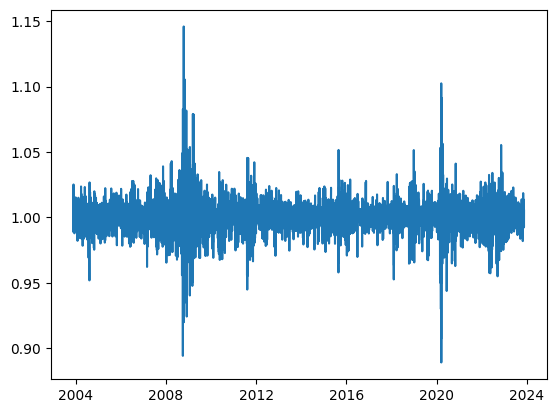

In [81]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df.index, arr_pfl[:-1])
plt.show()